In [ ]:
!mkdir GarbagePictures
!unzip GarbagePictures.zip -d GarbagePictures

In [ ]:
!pip install torch
!pip install torchvision
!pip install torchsummary
!pip install matplotlib
!pip install tqdm

In [4]:
# reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset
import PIL.Image as Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [5]:
class GarbageImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        f = open(annotations_file, 'r')
        self.img_labels = [line.split(' ') for line in f.readlines()]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        fname, label = self.img_labels[idx]
        img_path = self.img_dir +'/'+ fname
        img_pil = Image.open(img_path, mode='r')
        img_pil = img_pil.convert('RGB')
        image = pil_to_tensor(img_pil)
        label = int(label)-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
eval_transform = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 32

trainset = GarbageImageDataset('one-indexed-files_train.txt', './GarbagePictures', train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

valset = GarbageImageDataset('one-indexed-files_test.txt', './GarbagePictures', eval_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)


classes = ('glass','paper','cardboard','plastic','metal','trash')
trainset[0][0].shape


torch.Size([3, 256, 256])

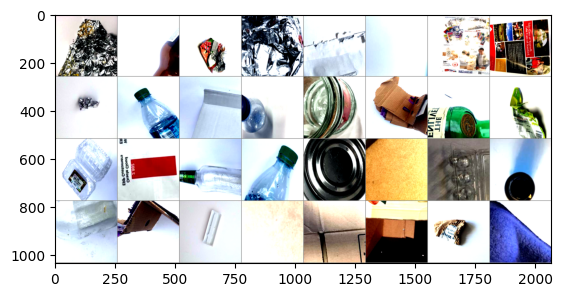

metal glass plastic metal paper plastic paper paper metal plastic cardboard plastic glass cardboard glass plastic plastic paper glass plastic metal cardboard plastic glass glass cardboard plastic cardboard cardboard cardboard cardboard paper


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
# define network

from torchvision import models
from torchsummary import summary
import torch.nn as nn

net = models.resnet50(pretrained=True).to(device)
net.fc = nn.Linear(in_features=2048, out_features=6).to(device)
summary(net, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from tqdm.auto import tqdm

train_loss = []
train_acc = []
val_acc = []

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    correct_guess = 0
    data_cnt = 0
    progress = tqdm(total=len(trainset))
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        guess_labels = torch.argmax(outputs, dim=1)
        correct_guess += torch.sum((guess_labels==labels))
        running_loss += loss.item()
        progress.update(len(inputs))

    train_loss.append(running_loss / len(trainset))
    train_acc.append(correct_guess / len(trainset))
    print(f'[epoch {epoch + 1}] train accuracy: {correct_guess / len(trainset):.3f}')

    correct_guess = 0
    progress = tqdm(total=len(valset))
    for i, data in enumerate(valloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward
        outputs = net(inputs)
        guess_labels = torch.argmax(outputs, dim=1)
        correct_guess += torch.sum((guess_labels==labels))
        progress.update(len(inputs))

    val_acc.append(correct_guess / len(valset))
    print(f'[epoch {epoch + 1}] val accuracy: {correct_guess / len(valset):.3f}')


print('Finished Training')

In [32]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

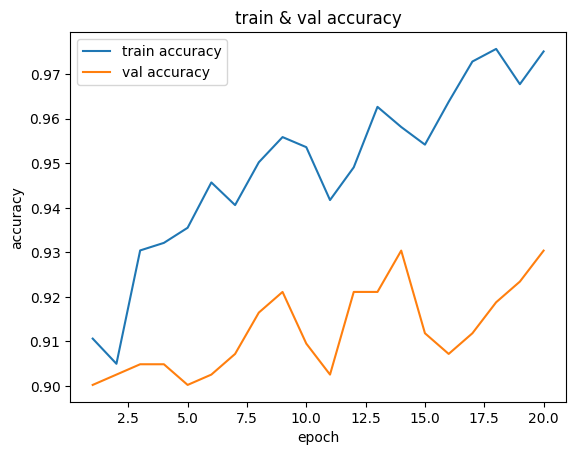

In [35]:
# importing package
import matplotlib.pyplot as plt

# plot lines
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('train & val accuracy')
plt.plot(range(1,21), [x.cpu() for x in train_acc], label = "train accuracy")
plt.plot(range(1,21), [x.cpu() for x in val_acc], label = "val accuracy")
plt.legend()
plt.show()

In [37]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: glass is 95.1 %
Accuracy for class: paper is 92.6 %
Accuracy for class: cardboard is 92.9 %
Accuracy for class: plastic is 94.6 %
Accuracy for class: metal is 95.6 %
Accuracy for class: trash is 79.3 %
